# Midterm Exam

## General information

This is the problem description for the midterm project of the course *"Data Science for Dynamical Systems"* (Winter Term 2025/26)

Below, you will find two tasks, accompanied by two datasets.

#### IMPORTANT: out of these, you should only select **one** task as your project!

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


# Task 1: Unknown Ordinary Differential Equation (ODE)

This dataset contains 
* $m=200$ trajectories,
* with $N=201$ time steps each,
* with time step $dt=0.01$ (i.e., the trajectories have length $(t_0,t_e)=(0,2)$).

The data has been 
* collected from an unknown ODE with state dimension $n=2$,
* corrupted with zero-mean Gaussian noise,
* stored in a 3D array $X_\text{ode}\in\mathbb{R}^{m \times N \times n}$, meaning that the individual trajectories can be accessed using the command `X_ode[i, :, :]`.

**Task:**
* **Train a model using the dataset $X_\text{ode}$ that predicts the system behavior as accurately as possible over $N_p=100$ time steps, for arbitrary initial conditions $x_0\in[-2,2]^2$.** 
* The error should be measured as the MSE between the predicted state and the ground truh (i.e., the given data).
* You may either train a black-box model or identify the governing equations from data.


### Load and visualize dataset

In [3]:
X_ode = np.load("ODE.npy")
dt_ode, t0_ode, te_ode = 0.01, 0, 2
m, N, n = X_ode.shape

In [16]:
X_ode.shape

(200, 201, 2)

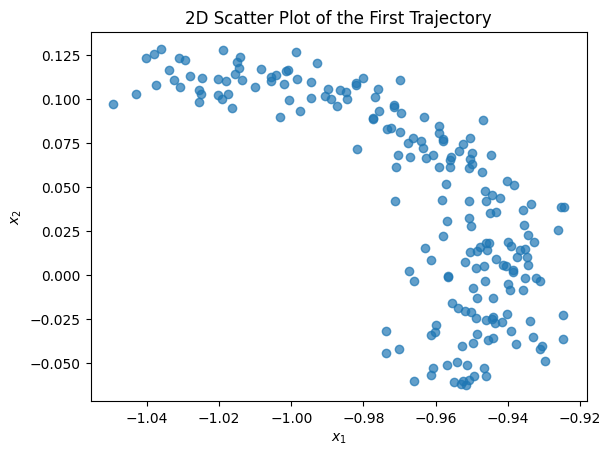

In [26]:
plt.scatter(X_ode[0][:, 0], X_ode[0][:, 1], alpha=0.7)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("2D Scatter Plot of the First Trajectory")
plt.show()


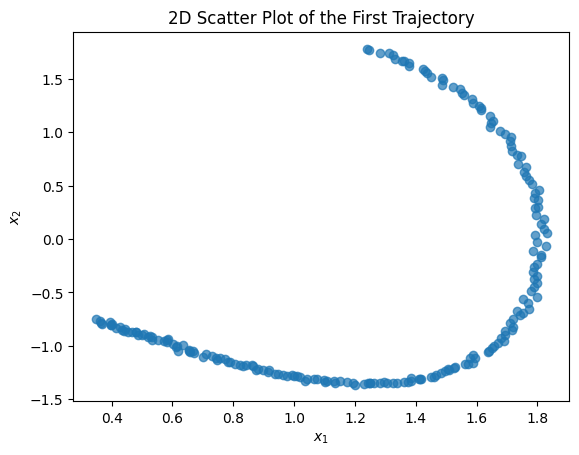

In [34]:
plt.scatter(X_ode[:][10][:][:, 0], X_ode[:][10][:][:, 1], alpha=0.7)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("2D Scatter Plot of the First Trajectory")
plt.show()

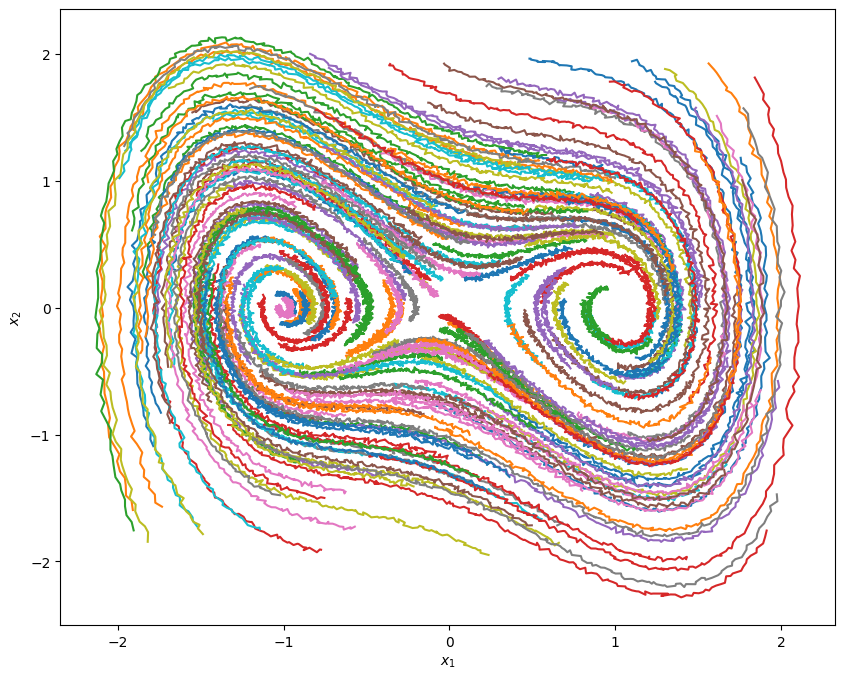

In [ ]:
plt.figure(figsize=(10, 8))
for traj in X_ode:
    plt.plot(traj[:,0], traj[:,1])
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
plt.show()

In [4]:
def compute_derivatives(X, dt):
    """
    X: (m, N, n) trajectories
    returns:
        X_flat: (M, n)
        Xdot_flat: (M, n)
    where M = m * (N - 2)  (due to central difference)
    """
    m, N, n = X.shape
    X_list, Xdot_list = [], []

    for traj in X:  # (N, n)
        # central differences for interior points
        x = traj
        xdot = (x[2:, :] - x[:-2, :]) / (2 * dt)  # (N-2, n)
        X_mid = x[1:-1, :]                        # (N-2, n)

        X_list.append(X_mid)
        Xdot_list.append(xdot)

    X_flat = np.vstack(X_list)
    Xdot_flat = np.vstack(Xdot_list)
    return X_flat, Xdot_flat

X_flat, Xdot_flat = compute_derivatives(X_ode, dt_ode)
print(X_flat.shape, Xdot_flat.shape)


(39800, 2) (39800, 2)


In [5]:
M = X_flat.shape[0]
idx = np.random.permutation(M)
train_size = int(0.8 * M)

train_idx = idx[:train_size]
test_idx = idx[train_size:]

X_train, Xdot_train = X_flat[train_idx], Xdot_flat[train_idx]
X_test,  Xdot_test  = X_flat[test_idx], Xdot_flat[test_idx]


In [6]:
def build_library(X, poly_order=3, include_sine=False):
    """
    X: (M, n)
    returns Theta: (M, p) feature matrix and feature_names
    """
    M, n = X.shape
    Theta_list = []
    names = []

    # constant
    Theta_list.append(np.ones((M, 1)))
    names.append("1")

    # linear
    for i in range(n):
        Theta_list.append(X[:, i:i+1])
        names.append(f"x{i+1}")

    if poly_order >= 2:
        for i in range(n):
            for j in range(i, n):
                Theta_list.append((X[:, i] * X[:, j])[:, None])
                names.append(f"x{i+1} x{j+1}")

    if poly_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    Theta_list.append((X[:, i] * X[:, j] * X[:, k])[:, None])
                    names.append(f"x{i+1} x{j+1} x{k+1}")

    if include_sine:
        for i in range(n):
            Theta_list.append(np.sin(X[:, i:i+1]))
            names.append(f"sin(x{i+1})")

    Theta = np.hstack(Theta_list)
    return Theta, names

Theta_train, lib_names = build_library(X_train, poly_order=3, include_sine=False)
Theta_test,  _         = build_library(X_test,  poly_order=3, include_sine=False)

print(Theta_train.shape)
print(lib_names[:10])


(31840, 10)
['1', 'x1', 'x2', 'x1 x1', 'x1 x2', 'x2 x2', 'x1 x1 x1', 'x1 x1 x2', 'x1 x2 x2', 'x2 x2 x2']


In [9]:
def fit_sindy(Theta, Xdot, alpha=1e-4):
    """
    Theta: (M, p)
    Xdot: (M, n)
    returns Xi: (p, n) sparse coefficient matrix
    """
    M, p = Theta.shape
    _, n = Xdot.shape
    Xi = np.zeros((p, n))

    for k in range(n):
        model = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
        model.fit(Theta, Xdot[:, k])
        Xi[:, k] = model.coef_
    return Xi

Xi = fit_sindy(Theta_train, Xdot_train, alpha=1e-4)


In [10]:
for k in range(n):
    print(f"\nDynamics for x_{k+1}:")
    for coef, name in zip(Xi[:, k], lib_names):
        if abs(coef) > 1e-6:
            print(f"  {coef:+.4f} * {name}")



Dynamics for x_1:
  +0.0013 * 1
  +0.0018 * x1
  +0.9966 * x2
  -0.0019 * x1 x1
  -0.0035 * x1 x2
  -0.0029 * x2 x2
  -0.0021 * x1 x1 x1
  -0.0031 * x1 x1 x2
  -0.0005 * x1 x2 x2
  +0.0026 * x2 x2 x2

Dynamics for x_2:
  -0.0062 * 1
  +0.9927 * x1
  -0.4911 * x2
  +0.0033 * x1 x1
  -0.0037 * x1 x2
  +0.0005 * x2 x2
  -0.9950 * x1 x1 x1
  +0.0001 * x1 x1 x2
  -0.0032 * x2 x2 x2


In [11]:
def library_single_x(x, poly_order=3, include_sine=False):
    """
    x: (n,) single state
    returns phi(x): (p,)
    using the same ordering as build_library
    """
    x = np.asarray(x)
    n = x.shape[0]
    features = [1.0]

    # linear
    for i in range(n):
        features.append(x[i])

    # quadratic
    if poly_order >= 2:
        for i in range(n):
            for j in range(i, n):
                features.append(x[i] * x[j])

    # cubic
    if poly_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    features.append(x[i] * x[j] * x[k])

    if include_sine:
        for i in range(n):
            features.append(np.sin(x[i]))

    return np.array(features)


def f_learned(x, Xi, poly_order=3, include_sine=False):
    phi = library_single_x(x, poly_order=poly_order, include_sine=include_sine)
    return phi @ Xi   # (n,)


def rk4_step(x, dt, rhs, *rhs_args):
    k1 = rhs(x, *rhs_args)
    k2 = rhs(x + 0.5*dt*k1, *rhs_args)
    k3 = rhs(x + 0.5*dt*k2, *rhs_args)
    k4 = rhs(x + dt*k3, *rhs_args)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0


In [13]:
def simulate_learned_ode(X_ode, Xi, n_steps=100, dt_data=0.01, substeps=5):
    """
    Evaluate learned ODE model on random initial conditions chosen from
    the first 301 time steps (or less, if the trajectory is shorter).

    X_ode: (m, N, n) array of trajectories
    Xi:    (p, n) coefficient matrix from SINDy
    """
    m, N, n = X_ode.shape
    dt_sim = dt_data / substeps

    # number of ICs
    num_ics = 20
    rng = np.random.default_rng(0)

    # how many steps can we actually take, given the data?
    max_horizon = min(n_steps, N - 1, 300)   # at most 300 as stated in the exam
    if max_horizon < 1:
        raise ValueError("Not enough time steps in the data for the chosen n_steps.")

    # start indices only where we have enough future data
    max_start = min(301, N) - max_horizon - 1
    if max_start < 0:
        max_start = 0

    traj_idx = rng.integers(0, m, size=num_ics)
    time_idx = rng.integers(0, max_start + 1, size=num_ics)

    mses = []

    for ti, ki in zip(traj_idx, time_idx):
        # take a segment of length (max_horizon + 1)
        x0 = X_ode[ti, ki].copy()
        x_true = X_ode[ti, ki:ki + max_horizon + 1]   # (T+1, n)
        T = x_true.shape[0] - 1                      # actual number of steps

        # allocate simulation array with the same length
        x_sim = np.zeros_like(x_true)
        x_sim[0] = x0

        for k in range(T):
            x = x_sim[k].copy()
            for _ in range(substeps):
                x = rk4_step(x, dt_sim, f_learned, Xi)
            x_sim[k + 1] = x

        mses.append(mean_squared_error(x_true, x_sim))

    return float(np.mean(mses)), mses


mean_mse, all_mses = simulate_learned_ode(X_ode, Xi)
print("Mean trajectory MSE:", mean_mse)


Mean trajectory MSE: 0.00029191414088577033
